Reference: https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
batchSize = 16 # 64
imgHeight = 199
imgWidth = 199

# dataPath = "datasets/food-101/food-101/images/"
dataPath = "FastFood"

trainDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="training",
  color_mode = "rgb", 
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

valDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="validation",
  color_mode = "rgb",
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)




Found 7000 files belonging to 7 classes.
Using 5600 files for training.
Found 7000 files belonging to 7 classes.
Using 1400 files for validation.


In [3]:
valBatch = tf.data.experimental.cardinality(valDataset)
testDataset = valDataset.take((2*valBatch) // 3)
valDataset = valDataset.skip((2*valBatch) // 3)

In [4]:
df = pd.read_csv('datasets/nutrition101 (1).csv')
protein_labels = list(df['protein'])
name_labels = list(df['name'])

In [5]:
def regression_dataset(data_list):
    def convt_labels(imgs, label):
        def convert_label(label):
            return np.array([data_list[int(y_i)] for y_i in label.numpy()])
        numeric_label = tf.py_function(convert_label, [label], tf.int32)
        return imgs, numeric_label
    return convt_labels

In [6]:
trainDataset = trainDataset.map(regression_dataset(protein_labels))
testDataset = testDataset.map(regression_dataset(protein_labels))
valDataset = valDataset.map(regression_dataset(protein_labels))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

trainDataset = trainDataset.cache().prefetch(buffer_size=AUTOTUNE)
valDataset = valDataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
numClasses = 101

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),


  InceptionV3(weights="imagenet", include_top=False),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.2),

  # tf.keras.layers.Conv2D(32, 11, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(32, 5, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),


  # tf.keras.layers.Dropout(0.7),

  # tf.keras.layers.Flatten(),
  
  # tf.keras.layers.Dense(514, activation='sigmoid'),
  # tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.005))
])

In [9]:
learningRate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=learningRate, momentum=0.9),
  loss=tf.keras.losses.MSE,
  metrics=['mse', 'mae'])

In [10]:
history = model.fit(
  trainDataset,
  validation_data=valDataset,
  epochs=30,
  callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="bestInceptionRegFF.h5", verbose=1, save_best_only=True)]
)

Epoch 1/30


350/350 [==============================] - ETA: 0s - loss: 29.0427 - mse: 29.0338 - mae: 4.0289
Epoch 1: val_loss improved from inf to 21.63492, saving model to bestInceptionRegFF.h5
350/350 [==============================] - 71s 167ms/step - loss: 29.0427 - mse: 29.0338 - mae: 4.0289 - val_loss: 21.6349 - val_mse: 21.4372 - val_mae: 3.2004
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 13.7467 - mse: 13.7381 - mae: 2.5780
Epoch 2: val_loss improved from 21.63492 to 20.85405, saving model to bestInceptionRegFF.h5
350/350 [==============================] - 53s 152ms/step - loss: 13.7467 - mse: 13.7381 - mae: 2.5780 - val_loss: 20.8541 - val_mse: 20.9344 - val_mae: 3.1662
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 5.9528 - mse: 5.9439 - mae: 1.6978
Epoch 3: val_loss improved from 20.85405 to 19.07208, saving model to bestInceptionRegFF.h5
350/350 [==============================] - 54s 153ms/step - loss: 5.9528 - mse: 5.9439 - mae: 1.6978 

In [11]:
y_pred = model.predict(testDataset)
print(y_pred)
print(model.evaluate(testDataset))

58/58 [==============================] - 5s 63ms/step
[[ 4.704778  ]
 [16.517708  ]
 [13.861992  ]
 [ 1.1061727 ]
 [16.768028  ]
 [ 5.1458874 ]
 [17.070087  ]
 [17.260544  ]
 [15.266585  ]
 [ 6.6125965 ]
 [ 0.9959737 ]
 [ 2.9354868 ]
 [17.176094  ]
 [17.791784  ]
 [ 5.39823   ]
 [14.291875  ]
 [16.662668  ]
 [ 6.8413706 ]
 [ 5.621527  ]
 [17.262653  ]
 [ 2.0555532 ]
 [17.039886  ]
 [ 2.532591  ]
 [16.86376   ]
 [16.575186  ]
 [ 9.26997   ]
 [17.04238   ]
 [17.114641  ]
 [ 6.5094223 ]
 [ 3.3653393 ]
 [ 5.3009844 ]
 [ 5.1483436 ]
 [ 1.5937026 ]
 [ 5.9676743 ]
 [17.313677  ]
 [ 3.129795  ]
 [ 8.126793  ]
 [17.201468  ]
 [15.749032  ]
 [ 5.784607  ]
 [ 3.0762126 ]
 [ 1.3906335 ]
 [ 5.0305967 ]
 [17.01575   ]
 [ 2.1453774 ]
 [16.446775  ]
 [17.496342  ]
 [ 5.178519  ]
 [ 7.0150657 ]
 [ 5.3728824 ]
 [17.097736  ]
 [ 0.8378844 ]
 [ 5.904163  ]
 [ 8.110409  ]
 [ 2.8057985 ]
 [16.743797  ]
 [ 4.486667  ]
 [16.568916  ]
 [16.979485  ]
 [17.589157  ]
 [ 2.9210057 ]
 [ 1.0632133 ]
 [16.55491   ]
 

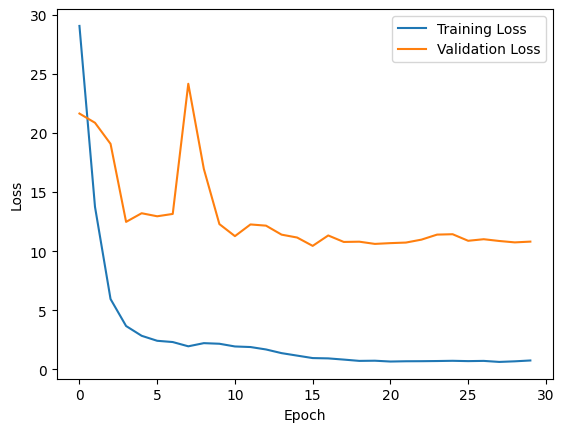

In [12]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.save_weights("inceptionRegFF.h5")